Problem Statement:

Identify the trends in sub-areas of marketing and e-commerce with combination of exploratory topic models and powerful predictive marketing models.

Context of Data

Company - UK-based and registered non-store online retail

Products for selling - Mainly all-occasion gifts

Customers - Most are wholesalers (local or international)

Transactions Period - 1st Dec 2010 - 9th Dec 2011 (One year)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import missingno as msno # missing data visualization module for Python
import pandas_profiling

import gc
import datetime

%matplotlib inline
color = sns.color_palette()

In [2]:
#pd.set_option('display.max_rows', 10000)
#pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('data.csv', encoding = 'ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# change the column names
df.rename(index=str, columns={'InvoiceNo': 'invoice_num',
                              'StockCode' : 'stock_code',
                              'Description' : 'description',
                              'Quantity' : 'quantity',
                              'InvoiceDate' : 'invoice_date',
                              'UnitPrice' : 'unit_price',
                              'CustomerID' : 'cust_id',
                              'Country' : 'country'}, inplace=True)

In [5]:
# check missing values for each column 
df.isnull().sum().sort_values(ascending=False)

cust_id         135080
description       1454
country              0
unit_price           0
invoice_date         0
quantity             0
stock_code           0
invoice_num          0
dtype: int64

In [6]:
# change the invoice_date format - String to Timestamp format
df['invoice_date'] = pd.to_datetime(df.invoice_date, format='%m/%d/%Y %H:%M')

In [7]:
# change description - UPPER case to LOWER case
df['description'] = df.description.str.lower()

Remove row with missing values

In [8]:
# df_new after dropping all NaN values
df_new = df.dropna()
df_new.head(2)

,invoice_num,stock_code,description,quantity,invoice_date,unit_price,cust_id,country
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [9]:
# check missing values for each column after drop
df_new.isnull().sum().sort_values(ascending=False)

country         0
cust_id         0
unit_price      0
invoice_date    0
quantity        0
description     0
stock_code      0
invoice_num     0
dtype: int64

In [10]:
# change columns tyoe - String to Int type 
df_new['cust_id'] = df_new['cust_id'].astype('int64')

In [11]:
df_new.describe().round(2)

,quantity,unit_price,cust_id
count,406829.00,406829.00,406829.00
mean,12.06,3.46,15287.69
std,248.69,69.32,1713.60
min,-80995.00,0.00,12346.00
25%,2.00,1.25,13953.00
50%,5.00,1.95,15152.00
75%,12.00,3.75,16791.00
max,80995.00,38970.00,18287.00


Remove quantity with negative values

In [12]:
df_new = df_new[df_new.quantity > 0]


In [13]:
df_new.describe().round(2)

,quantity,unit_price,cust_id
count,397924.00,397924.00,397924.00
mean,13.02,3.12,15294.32
std,180.42,22.10,1713.17
min,1.00,0.00,12346.00
25%,2.00,1.25,13969.00
50%,6.00,1.95,15159.00
75%,12.00,3.75,16795.00
max,80995.00,8142.75,18287.00


Add column - amount_spent

In [14]:
df_new['amount_spent'] = df_new['quantity'] * df_new['unit_price']

In [15]:
# rearrange all the columns for easy reference
df_new = df_new[['invoice_num','invoice_date','stock_code','description','quantity','unit_price','amount_spent','cust_id','country']]

Add the columns= month, day and hour of invoice

In [16]:
df_new.insert(loc=2, column='year_month', value=df_new['invoice_date'].map(lambda x: 100*x.year + x.month))
df_new.insert(loc=3, column='month', value=df_new.invoice_date.dt.month)
df_new.insert(loc=4, column='day', value=(df_new.invoice_date.dt.dayofweek)+1)
df_new.insert(loc=5, column='hour', value=df_new.invoice_date.dt.hour)

In [17]:
df_new.head(3)

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country
0,536365,2010-12-01 08:26:00,201012,12,3,8,85123A,white hanging heart t-light holder,6,2.55,15.30,17850,United Kingdom
1,536365,2010-12-01 08:26:00,201012,12,3,8,71053,white metal lantern,6,3.39,20.34,17850,United Kingdom
2,536365,2010-12-01 08:26:00,201012,12,3,8,84406B,cream cupid hearts coat hanger,8,2.75,22.00,17850,United Kingdom


Number of orders made by the each customer

In [18]:
df_new.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count().head()

,cust_id,country,invoice_num
0,12346,United Kingdom,1
1,12347,Iceland,182
2,12348,Finland,31
3,12349,Italy,73
4,12350,Norway,17


In [19]:
#Number of orders for different customer
#orders = df_new.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count()

#plt.subplots(figsize=(15,6))
#plt.plot(orders.cust_id, orders.invoice_num)
#plt.xlabel('Customers ID')
#plt.ylabel('Number of Orders')
#plt.title('Number of Orders for different Customers')
#plt.show()



The TOP 5 customers with most number of orders...

In [20]:

orders = df_new.groupby(by=['cust_id','country'], as_index=False)['invoice_num'].count()
orders.sort_values(by='invoice_num', ascending=False).head()

,cust_id,country,invoice_num
4019,17841,United Kingdom,7847
1888,14911,EIRE,5677
1298,14096,United Kingdom,5111
334,12748,United Kingdom,4596
1670,14606,United Kingdom,2700


Money spent by the customers


In [21]:
money_spent = df_new.groupby(by=['cust_id','country'], as_index=False)['amount_spent'].sum()
print('The TOP 5 customers with highest money spent...')
money_spent.sort_values(by='amount_spent', ascending=False).head()

The TOP 5 customers with highest money spent...


,cust_id,country,amount_spent
1698,14646,Netherlands,280206.02
4210,18102,United Kingdom,259657.30
3737,17450,United Kingdom,194550.79
3017,16446,United Kingdom,168472.50
1888,14911,EIRE,143825.06


In [22]:
print('The TOP 5 customers with least money spent...')
money_spent.sort_values(by='amount_spent', ascending=True).head()

The TOP 5 customers with least money spent...


,cust_id,country,amount_spent
693,13256,United Kingdom,0.00
3226,16738,United Kingdom,3.75
1802,14792,United Kingdom,6.20
3023,16454,United Kingdom,6.90
4107,17956,United Kingdom,12.75


In [23]:
print('Average money spent by any customer....')
money_spent.amount_spent.mean()

Average money spent by any customer....


2050.0133204508875

Note the variation in money spent by any person on e-commerce

## Discover patterns of Number of Orders

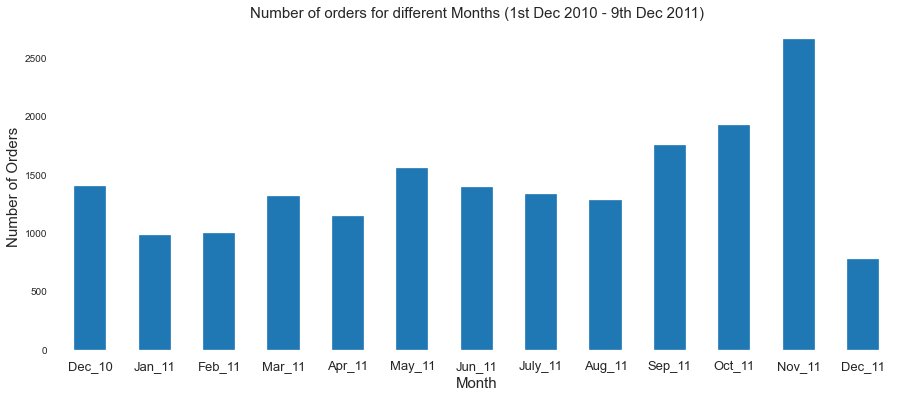

In [24]:
ax = df_new.groupby('invoice_num')['year_month'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','Jun_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11','Dec_11'), rotation='horizontal', fontsize=13)
plt.show()

It illustrates that the sale of gift remain stable through the year with minimum 1000 order per month which is considerable good for any bussiness.

In [25]:
#number of order per day
#df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index()
#ax = df_new.groupby('invoice_num')['day'].unique().value_counts().sort_index().plot(kind='bar',color=color[0],figsize=(15,6))

In [26]:
#No. of orders per hour
#ax = df_new.groupby('invoice_num')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color=color[0],figsize=(15,6))

## Discover patterns for each Country

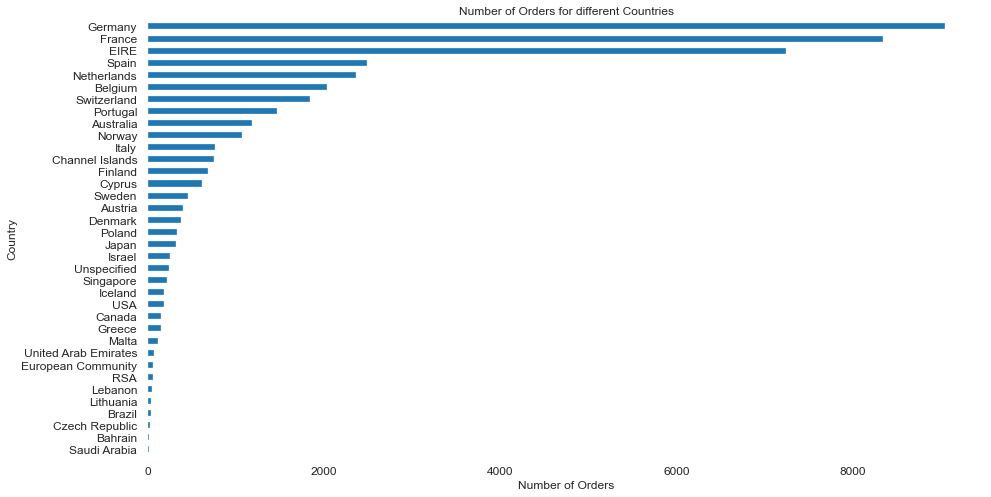

In [27]:
group_country_orders = df_new.groupby('country')['invoice_num'].count().sort_values()
del group_country_orders['United Kingdom']

#plot number of unique customers in each country (with UK)
plt.subplots(figsize=(15,8))
group_country_orders.plot(kind='barh', fontsize=12, color=color[0])
plt.xlabel('Number of Orders', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.title('Number of Orders for different Countries', fontsize=12)
plt.show()

In [28]:
#money spent by each country
#group_country_amount_spent = df_new.groupby('country')['amount_spent'].sum().sort_values()
#del group_country_orders['United Kingdom']


Discover patterns for Unit Price

In [29]:
df_new.unit_price.describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: unit_price, dtype: float64

**We see that there are unit price = 0 (FREE items)**

There are some free items given to customers from time to time

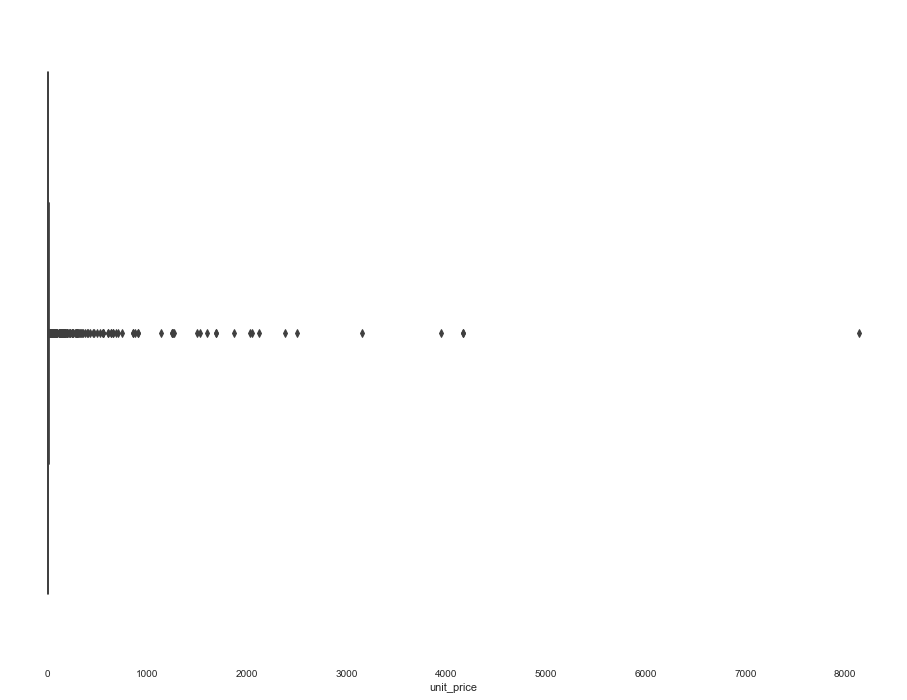

In [30]:
# check the distribution of unit price
plt.subplots(figsize=(16,12))

sns.boxplot(df_new.unit_price)
plt.show()

In [31]:
df_free = df_new[df_new.unit_price == 0]
df_free.head(2)

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country
9302,537197,2010-12-05 14:02:00,201012,12,7,14,22841,round cake tin vintage green,1,0.0,0.0,12647,Germany
33576,539263,2010-12-16 14:36:00,201012,12,4,14,22580,advent calendar gingham sack,4,0.0,0.0,16560,United Kingdom


For unit_price

mean          3.116174

std          22.096788

min           0.000000

25%           1.250000

50%           1.950000

75%           3.750000

max        8142.750000

Let's check whether customer go for high-valued product or low-valued product taking 1000 as separation point cause 75 percentile of value is quite low

In [32]:
df_less = df_new[df_new.unit_price <1000]
df_more = df_new[df_new.unit_price >=1000]
df_3quartile=df_new[df_new.unit_price >=3.75]

Number of free items given


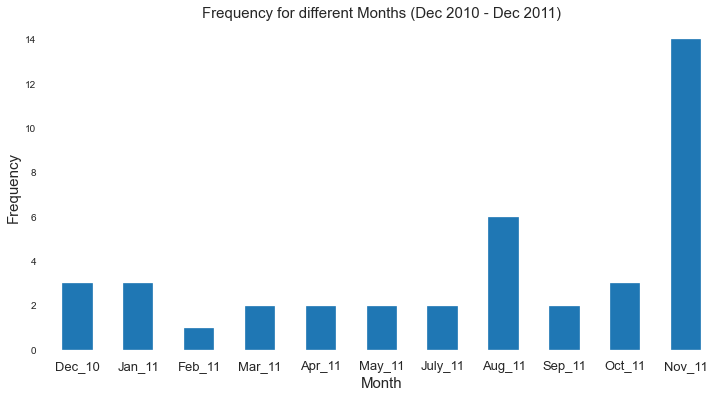

In [33]:
print('Number of free items given')
ax = df_free.year_month.value_counts().sort_index().plot(kind='bar',figsize=(12,6), color=color[0])
ax.set_xlabel('Month',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_title('Frequency for different Months (Dec 2010 - Dec 2011)',fontsize=15)
ax.set_xticklabels(('Dec_10','Jan_11','Feb_11','Mar_11','Apr_11','May_11','July_11','Aug_11','Sep_11','Oct_11','Nov_11'), rotation='horizontal', fontsize=13)
plt.show()

On average, the company gave out 2-4 times FREE items to customers each month (Except in June 2011). The exact reason or marketing strategies is not known.


## Check the number of times an item is reorder

In [34]:
df_sort = df_new.sort_values(['cust_id', 'stock_code', 'invoice_date'])
df_sort_shift1 = df_sort.shift(1)
df_sort_reorder = df_sort.copy()
df_sort_reorder['reorder'] = np.where(df_sort['stock_code'] == df_sort_shift1['stock_code'], 1,0)
df_sort_reorder.tail(5)

,invoice_num,invoice_date,year_month,month,day,hour,stock_code,description,quantity,unit_price,amount_spent,cust_id,country,reorder
198742,554065,2011-05-22 10:39:00,201105,5,7,10,85039B,s/4 ivory mini rose candle in bowl,12,1.65,19.80,18287,United Kingdom,1
392744,570715,2011-10-12 10:23:00,201110,10,3,10,85039B,s/4 ivory mini rose candle in bowl,48,1.45,69.60,18287,United Kingdom,1
198740,554065,2011-05-22 10:39:00,201105,5,7,10,85040A,s/4 pink flower candles in bowl,36,1.65,59.40,18287,United Kingdom,0
198743,554065,2011-05-22 10:39:00,201105,5,7,10,85040A,s/4 pink flower candles in bowl,12,1.65,19.80,18287,United Kingdom,1
392743,570715,2011-10-12 10:23:00,201110,10,3,10,85173,set/6 frog prince t-light candles,48,1.69,81.12,18287,United Kingdom,0


In [35]:
#Top 10 Reorder item
df_all=pd.DataFrame((df_sort_reorder.groupby(['description'])['reorder'].sum())).sort_values('reorder', ascending = False)
df_all.head(10)

,reorder
description,
white hanging heart t-light holder,1172
jumbo bag red retrospot,983
regency cakestand 3 tier,843
lunch bag red retrospot,785
postage,768
assorted colour bird ornament,730
party bunting,689
lunch bag black skull.,647
lunch bag suki design,621


Check for item in reorder list for free item and count it

In [36]:
df_free_reorder=df_sort_reorder[df_sort_reorder.unit_price==0]
df_free_reorder=df_free_reorder[df_sort_reorder.reorder>0]
df_free_reorder.invoice_num.count()

29

In [37]:
df_free.invoice_num.count()

40

It shows that 29 out 40 items given as free is reorder.
It is a positive indication for advertisement and sales.

Check for reordering of high or low valued items

In [38]:
#First Item Order
df_sort = df_less.sort_values(['cust_id', 'stock_code', 'invoice_date'])
df_sort_shift1 = df_sort.shift(1)
df_sort_reorder = df_sort.copy()
df_sort_reorder['reorder'] = np.where(df_sort['stock_code'] == df_sort_shift1['stock_code'], 1,0)
#df_sort_reorder.head(5)

In [41]:
#Top low valued reorder item
pd.DataFrame((df_sort_reorder.groupby(['description'])['reorder'].sum())).sort_values('reorder', ascending = False).head(10)

,reorder
description,
white hanging heart t-light holder,1172
jumbo bag red retrospot,983
regency cakestand 3 tier,843
lunch bag red retrospot,785
postage,768
assorted colour bird ornament,730
party bunting,689
lunch bag black skull.,647
lunch bag suki design,621


In [42]:

df_sort = df_more.sort_values(['cust_id', 'stock_code', 'invoice_date'])
df_sort_shift1 = df_sort.shift(1)
df_sort_reorder = df_sort.copy()
df_sort_reorder['reorder'] = np.where(df_sort['stock_code'] == df_sort_shift1['stock_code'], 1,0)
#df_sort_reorder.head(5)


In [43]:
#Top high valued item
pd.DataFrame((df_sort_reorder.groupby(['description'])['reorder'].sum())).sort_values('reorder', ascending = False).head(10)

,reorder
description,
manual,13
dotcom postage,3
postage,0


In [ ]:
#order_canceled = df_new['invoice_num'].apply(lambda x:int('C' in x))
#n1 = order_canceled.sum()
#n2 = df_new.shape[0]
#print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

## Topic Modelling

In [44]:

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models
pattern = r'\b[^\d\W]+\b'
tokenizer = RegexpTokenizer(pattern)
en_stop = get_stop_words('en')
lemmatizer = WordNetLemmatizer()

In [45]:
en_stop = get_stop_words('en')
en_stop.extend(['set','pack','small','white','black','heart','red','pink','blue','love','hot'])

In [47]:
# list for tokenized documents in loop
import re
import string

texts = []

    # loop through document list
for i in df_new['description'].iteritems():
    # clean and tokenize document string
        raw = str(i[1]).lower()
        raw = re.sub(r'\[.*?\]', '', raw)
        raw = re.sub(r'[%s]' % re.escape(string.punctuation), '',raw)
        raw= re.sub(r'\w*\d\w*', '', raw)
        raw= re.sub(r'\d+',"", raw)
        tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
        stopped_tokens_new = [raw for raw in tokens if not raw in en_stop]
        lemma_tokens = [lemmatizer.lemmatize(tokens) for tokens in stopped_tokens_new]
        new_lemma_tokens = [raw for raw in lemma_tokens if not len(raw) == 1]
    
    # add tokens to list
        texts.append(new_lemma_tokens)
        
        

In [48]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [49]:
import gensim
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=20)
import pprint
pprint.pprint(ldamodel.top_topics(corpus,topn=2))

[([(0.08965688, 'hanging'), (0.08913062, 'holder')], -0.856110557491156),
 ([(0.18356767, 'bag'), (0.08532255, 'jumbo')], -1.018911483789616),
 ([(0.15610074, 'christmas'), (0.102276556, 'vintage')], -1.3195285215906745),
 ([(0.07932767, 'paper'), (0.075935416, 'kit')], -1.3601180259235792),
 ([(0.051392756, 'ivory'), (0.05011604, 'wall')], -2.224431851543999),
 ([(0.10112737, 'cake'), (0.09367221, 'retrospot')], -2.267440679983328),
 ([(0.14961867, 'design'), (0.06361882, 'spaceboy')], -2.287946449092151),
 ([(0.06792361, 'tea'), (0.05522468, 'light')], -3.5978323247961743),
 ([(0.06221112, 'frame'), (0.06057826, 'mug')], -23.344404263972415),
 ([(0.10760158, 'wooden'), (0.1010778, 'tin')], -23.950739409714224)]


In [50]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.263847  0.014857       1        1  13.762842
9      0.093575  0.193334       2        1  12.000051
4     -0.345028 -0.100852       3        1  11.926070
8      0.130285 -0.147548       4        1  10.569513
6     -0.080920  0.083936       5        1   9.814434
5      0.046172  0.275351       6        1   9.404917
3      0.136586 -0.133649       7        1   8.979271
7      0.086636  0.052055       8        1   8.185227
0      0.102678  0.041912       9        1   8.073056
1      0.093862 -0.279397      10        1   7.284612, topic_info=           Term          Freq         Total Category  logprob  loglift
91          bag  35043.000000  35043.000000  Default  30.0000  30.0000
105   christmas  25823.000000  25823.000000  Default  29.0000  29.0000
92       design  21935.000000  21935.000000  Default  28.0000  28.0000
46      vintage  27135.000000  27135.000000  Default  27.0000  27.0000
141        cake  16833.000000  16833.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
296       mouse    797.801086    798.698547  Topic10  -4.8414   2.6183
337     cornice    754.876282    755.773743  Topic10  -4.8967   2.6182
1816   puncture    976.154724    985.555603  Topic10  -4.6397   2.6098
118      drawer   1318.311890   4069.584961  Topic10  -4.3392   1.4922
158     ceramic   1505.923462   6462.192383  Topic10  -4.2061   1.1628

[390 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
168       4  0.998146   acrylic
163       1  0.998702   airline
63        6  0.999876     alarm
47        7  0.999863  alphabet
431       3  0.999351     angel
...     ...       ...       ...
424       3  0.999755      wrap
497       4  0.999370    wreath
61        5  0.999381    yellow
199       3  0.417184      zinc
199       5  0.582478      zinc

[390 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 5, 9, 7, 6, 4, 8, 1, 2])

In [51]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words=en_stop)
doc_term_matrix = count_vect.fit_transform(df_new['description'].values.astype('U'))

In [52]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=10, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [54]:
for i,topic in enumerate(LDA.components_):
    print('Top 10 words for topic #{}:'.format(i+1))
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #1:
['hand', 'warmer', 'charlotte', 'paisley', 'retrospot', 'vintage', 'design', 'lunch', 'jumbo', 'bag']


Top 10 words for topic #2:
['stand', 'hanging', 'tier', 'light', 'silver', 'vintage', 'retrospot', 'glass', 'water', 'bottle']


Top 10 words for topic #3:
['english', 'trinket', 'lights', 'hook', 'craft', 'green', 'christmas', 'box', 'paper', 'rose']


Top 10 words for topic #4:
['zinc', 'wall', 'cookie', '50', 'ivory', 'vintage', 'star', 'decoration', 'wooden', 'christmas']


Top 10 words for topic #5:
['bunting', 'pencils', 'candles', 'tube', 'kit', 'polkadot', 'wicker', 'party', 'retrospot', 'large']


Top 10 words for topic #6:
['edwardian', 'kitchen', 'wood', 'sweet', 'french', 'feltcraft', 'doormat', 'home', 'sign', 'metal']


Top 10 words for topic #7:
['box', 'assorted', 'birthday', 'card', 'ceramic', 'colour', '12', 'hanging', 'light', 'holder']


Top 10 words for topic #8:
['box', 'traditional', 'photo', 'tins', 'wooden', 'design', 'frame', 'pant

Summary:

The customer with the highest number of orders comes from the United Kingdom (UK) (since it is a UK-based company). 

The customer with the highest money spent on purchases comes from Netherlands

Usualy the highest sales accure in December (Dataset only until 2011-12-09)

Day 1 to 8 is the busiest day, after that sale start to decline

Majority of sale accure at 10:00 to 15:00, peak at 12:00

Most transaction accure during work hours

There are no transactions on Saturday between 1st Dec 2010 - 9th Dec 2011

The number of orders received by the company tends to increases from Monday to Thursday and decrese afterward




Therefore, the TOP 5 countries (including UK) that place the highest number of orders are as below:
United Kingdom
Germany
France
Ireland (EIRE)
Spain


Therefore, the TOP 5 countries (including UK) that spend the most money on purchases are as below:
United Kingdom
Netherlands
Ireland (EIRE)
Germany
France

